In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import sys
import os
from multiprocessing import Pool
from functools import partial
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm
import numpy as np
from dask.distributed import Client, progress, LocalCluster
from dask import compute, delayed
import dask.array as da
from dask.diagnostics import ProgressBar
plt.rcParams['figure.dpi']=400

# Problem 4.1

### Hamiltonian

In [2]:
def denseH(L, J, hx, hz, periodic):
    """
    generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim)) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= hx # contribution by sigma^j_x
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   

def diagonalize(Ls, J, hx, hz, periodic):
    
    eigss = []
    vecss = []
    
    for L in Ls:
        H = denseH(L, J, hx, hz, periodic)
        eigs, vecs = scipy.linalg.eigh(H)
        eigss.append(eigs)
        vecss.append(vecs)
    
    return eigss, vecss

### Diagonalizing the wave function right now, so I dont have to do it again

In [3]:
Ls = [6, 8, 10, 12, 14]
J = 1
hx = -1.05
hz = 0.5
periodic = True 

start_time = time.time()
eigss, vecss = diagonalize(Ls, J, hx, hz, periodic)
end_time = time.time()
print('time taken:', end_time-start_time)

time taken: 283.03254675865173


# Problem 4.1.1

### Translation-invariant product state wave function

In [6]:
eps = np.array([[1/2],[-np.sqrt(3)/2]])

def psi_initial(L):

    psi_0 = eps
    for _ in range(1, L):
        psi_0 = np.kron(psi_0, eps)
    
    return psi_0


### Matrix elements of the spin operators

In [62]:
def sigma(mu, vecs):
    
    N = len(vecs)
    
    sigma_vecs = np.zeros((len(vecs[0]), N), dtype = complex)
    
    for i in range(N):
        
        vec = vecs[:, i]

        for alpha in range(len(vec)):
        
            if mu == 'z':
                if alpha & 1 :
                    sigma_vecs[alpha, i] -= vec[alpha]
                else:
                    sigma_vecs[alpha, i] = vec[alpha]
                    
            elif mu == 'y':
                beta = alpha ^ 1 
                
                if alpha & 1:
                    sigma_vecs[beta, i] = -1j * vec[alpha]
                else:
                    sigma_vecs[beta, i] = 1j * vec[alpha]

            elif mu == 'x':
                beta = alpha ^ (1 << 0)
                sigma_vecs[beta, i] = vec[alpha]

    sigma_matrix = np.conj(vecs).T @ sigma_vecs
    
    return sigma_matrix


### Expectation value of the spin operators

In [63]:
def expectation_value(sigma_matrix, eigs, coeffs, t):

    delta_eigs = eigs[:, np.newaxis] - eigs[np.newaxis, :]
    
    phase_factors = np.exp(-1j * delta_eigs * t)
    
    coeff_matrix = np.outer(np.conj(coeffs), coeffs)
    
    total_matrix = coeff_matrix * phase_factors * sigma_matrix
    
    return np.real(np.sum(total_matrix))

## Plotting the time traces

In [77]:
dt = .1
T = np.arange(0,40, dt)

plt.figure(figsize=(10, 8))



for i in range(len(Ls)-1):
    
    L = Ls[i]
    eigs, vecs = eigss[i], vecss[i]
    psi = psi_initial(L)
    coeffs = vecs.conj().T @ psi
    sigma_matrix = sigma('x', vecs)

    Yarray = []
    for t in tqdm(T, desc=f'Processing L={L}'):
        Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))
        
    xkcd_colors=['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink']

    # Plot the time evolution
    plt.plot(T, Yarray, label=f'L={L}', color=xkcd_colors[i])
    

plt.axhline(y=sigma_thermal('x', eigs, vecs, 0.374), color='black', linestyle='--', label=f'Eq. Thermal State')


plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^X (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_X$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxsmooth.png'), dpi=400)
plt.show()


Processing L=6:   0%|          | 0/400 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/400 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/400 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000020BF5E4C2C0> (for post_execute):



KeyboardInterrupt



In [ ]:
dt = .1
T = np.arange(0,40, dt)

plt.figure(figsize=(10, 8))

for i in range(len(Ls)-1):
    
    L = Ls[i]
    eigs, vecs = eigss[i], vecss[i]
    psi = psi_initial(L)
    coeffs = vecs.conj().T @ psi
    sigma_matrix = sigma('y', vecs)

    Yarray = []
    for t in tqdm(T, desc=f'Processing L={L}'):
        Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))
        
    xkcd_colors=['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink']

    plt.plot(T, Yarray, label=f'L={L}', color=xkcd_colors[i])
    


plt.axhline(y=sigma_thermal('y', eigs, vecs, 0.374), color='black', linestyle='--', label=f'Eq. Thermal State')


plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^Y (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_Y$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaysmooth.png'), dpi=400)
plt.show()


In [ ]:
dt = .1
T = np.arange(0,40, dt)

plt.figure(figsize=(10, 8))

for i in range(len(Ls)-1):
    
    L = Ls[i]
    eigs, vecs = eigss[i], vecss[i]
    psi = psi_initial(L)
    coeffs = vecs.conj().T @ psi
    sigma_matrix = sigma('z', vecs)

    Yarray = []
    for t in tqdm(T, desc=f'Processing L={L}'):
        Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))
        
    xkcd_colors=['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink']

    # Plot the time evolution
    plt.plot(T, Yarray, label=f'L={L}', color=xkcd_colors[i])
    

plt.axhline(y=sigma_thermal('z', eigs, vecs, 0.374), color='black', linestyle='--', label=f'Eq. Thermal State')


plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^Z (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_Z$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmazsmooth.png'), dpi=400)
plt.show()


# Problem 4.1.2

Best beta for L=6: 0.37373737373737376 with energy difference: [[0.00281534]]
Best beta for L=8: 0.37373737373737376 with energy difference: [[0.01024373]]
Best beta for L=10: 0.37373737373737376 with energy difference: [[0.01460094]]
Best beta for L=12: 0.37373737373737376 with energy difference: [[0.01774221]]
Best beta for L=14: 0.37373737373737376 with energy difference: [[0.02072569]]


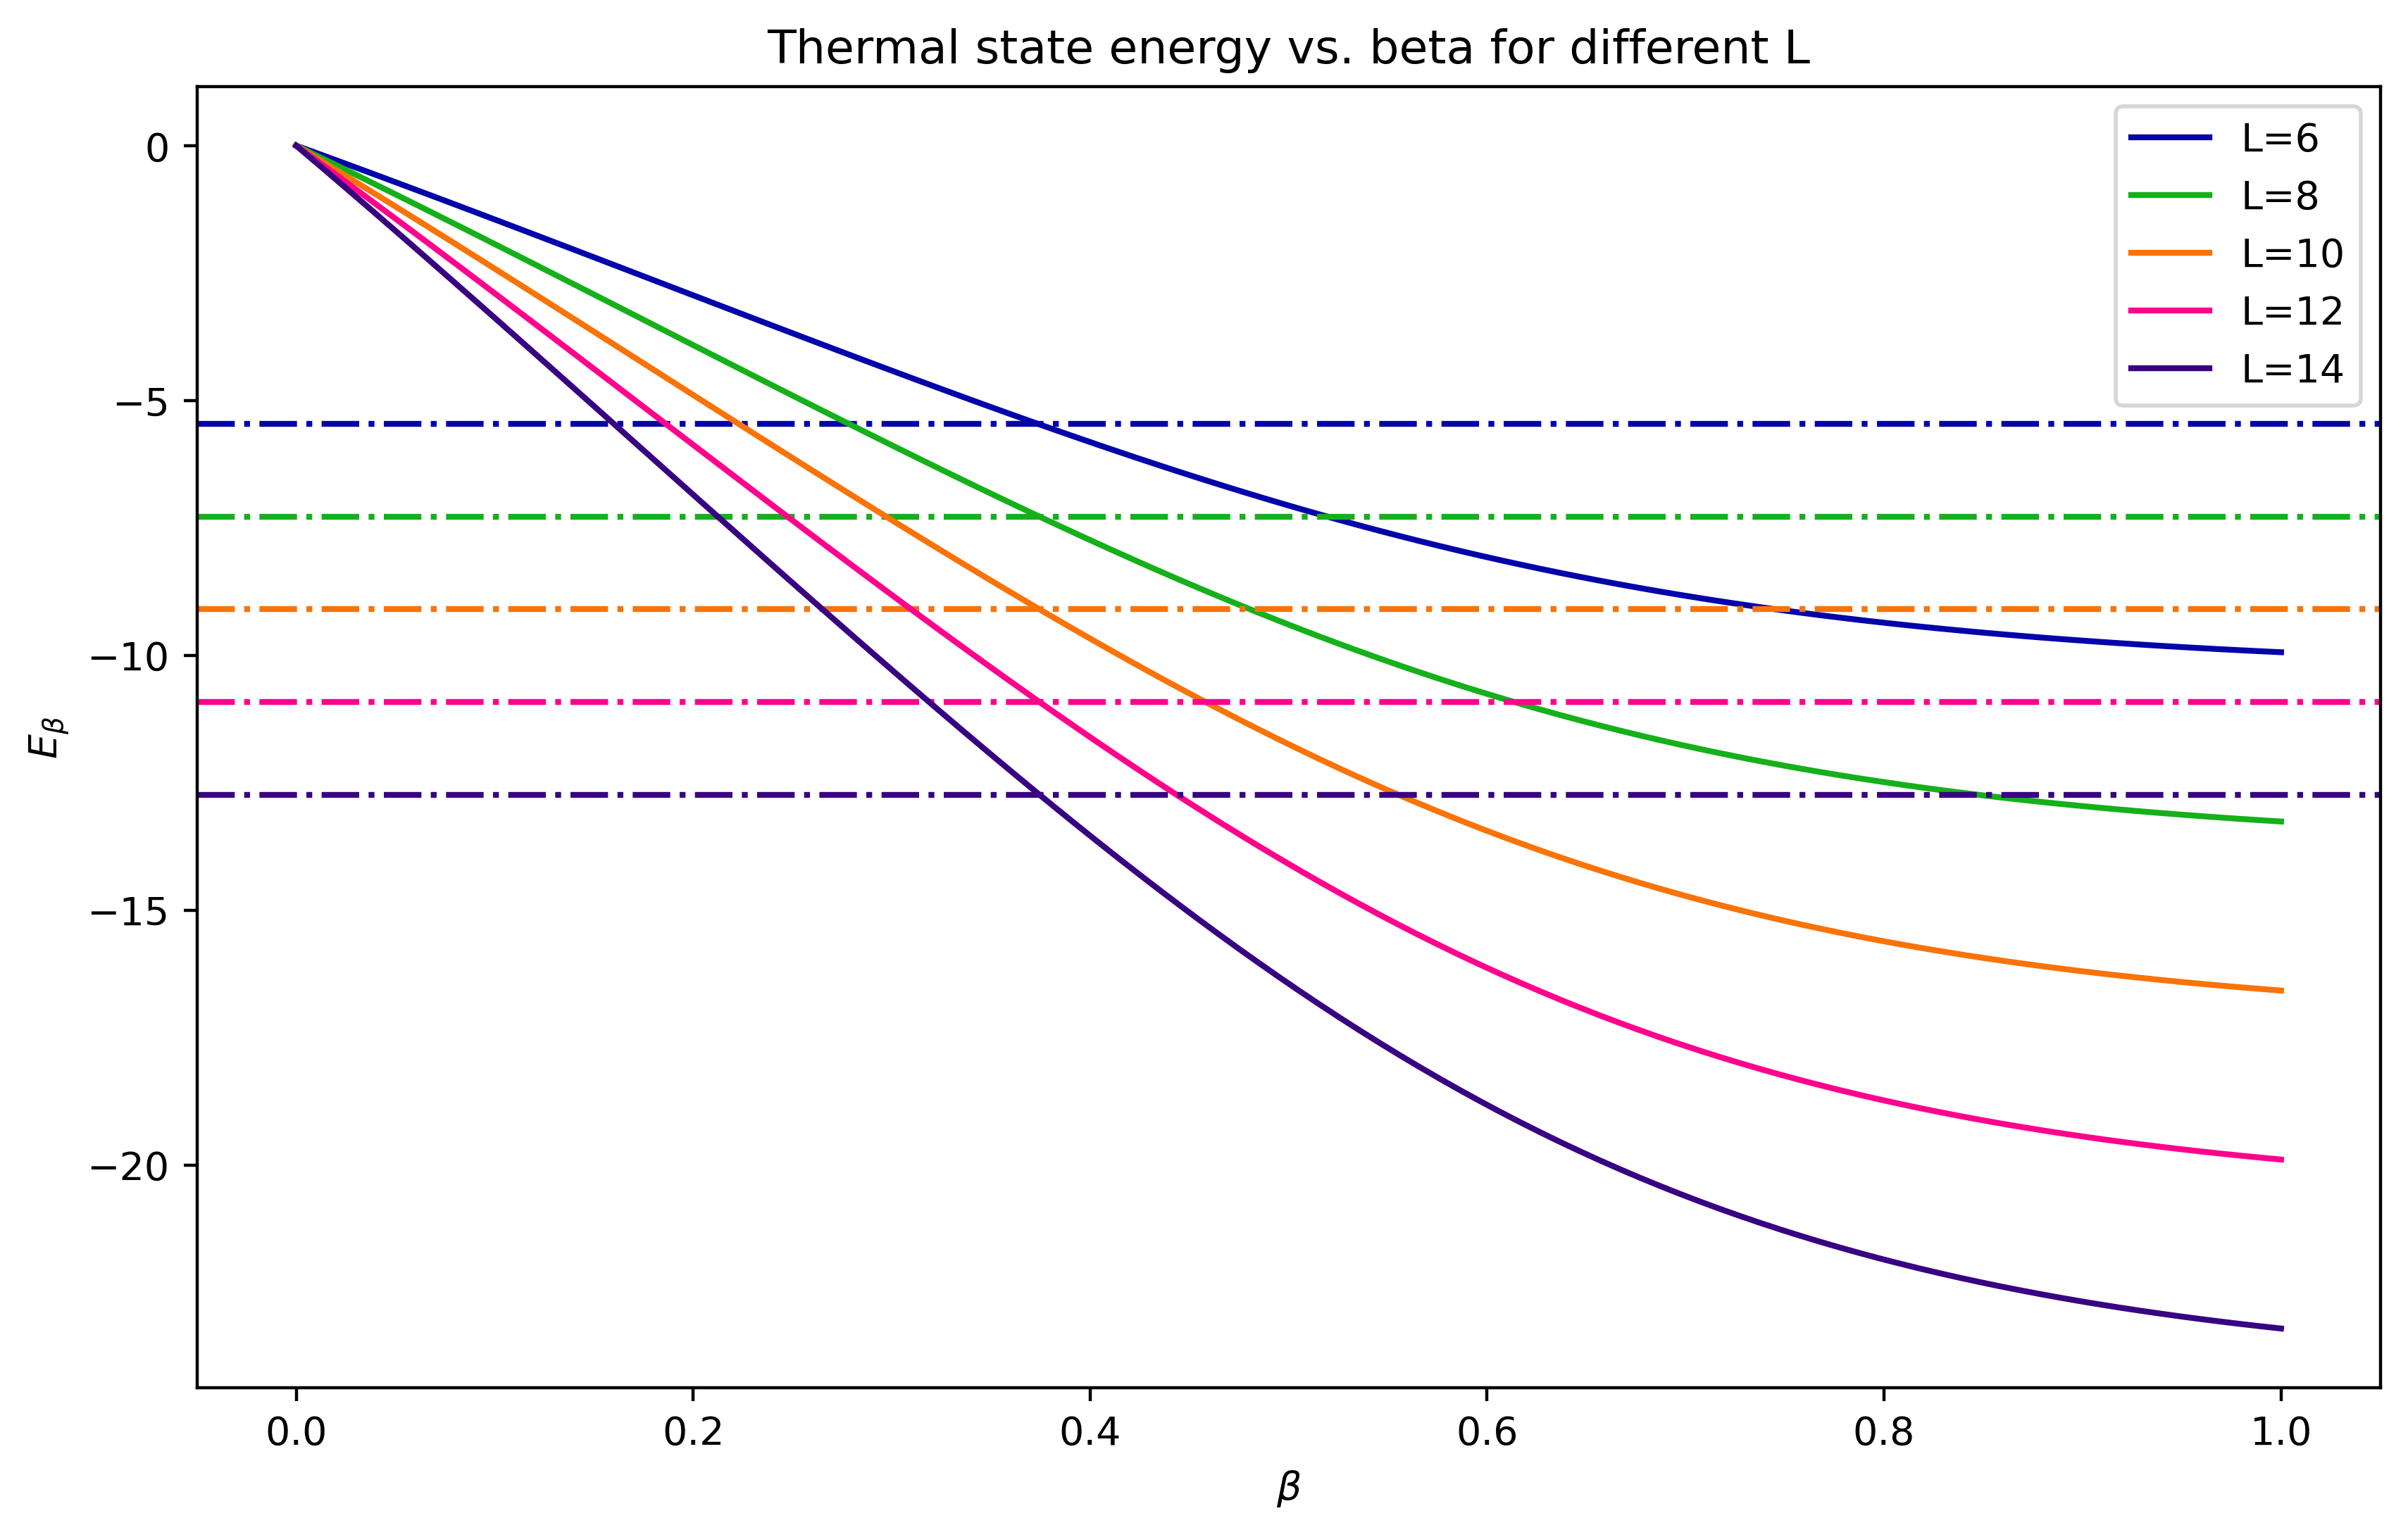

In [66]:
def thermal_state_energy(beta, eigs):
    
    Z = np.sum(np.exp(-beta*eigs))
    
    P = np.sum(np.exp(-beta*eigs)*eigs)
    
    return P/Z


def compute_thermal_energies(L, J, hx, hz, periodic, betas, eigs):
    psi = psi_initial(L)
    
    H = denseH(L, J, hx, hz, periodic)
    E = psi.T @ H @ psi
    
    energies = []
    min_diff = float('inf')
    best_beta = None

    for beta in betas:
        E_beta = thermal_state_energy(beta, eigs)
        diff = abs(E_beta - E)
        energies.append(E_beta)
        if diff < min_diff:
            min_diff = diff
            best_beta = beta

    print(f'Best beta for L={L}: {best_beta} with energy difference: {min_diff}')
    return energies, E

# betas = np.linspace(0.37, 0.375, 100)
betas = np.linspace(0, 1, 100)

all_energies = []
initial_energies = []

for i in range(len(Ls)):
    energies, E = compute_thermal_energies(Ls[i], J, hx, hz, periodic, betas, eigss[i])
    all_energies.append(energies)
    initial_energies.append(E)
    
xkcd_colors=['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink', 'xkcd:indigo']
plt.figure(figsize=(10, 6))
for i, energies in enumerate(all_energies):
    plt.plot(betas, energies, label=f'L={Ls[i]}', color=xkcd_colors[i])
    plt.axhline(y=initial_energies[i], linestyle='dashdot', color=xkcd_colors[i])

plt.title('Thermal state energy vs. beta for different L')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$E_\beta$')
plt.legend()
plt.savefig(os.path.join(directory, 'betas.png'), dpi=400)
plt.show()




### Thermal Value of the observables

In [67]:
def sigma_thermal(mu, eigs, vecs, beta_th):
    sigma_matrix = sigma(mu, vecs)  # Get the sigma matrix for the given mu

    N = len(vecs)
    
    P = 0.0
    Z = 0.0
    
    for n in range(N):
        Z += np.exp(-beta_th * eigs[n])  # Calculate the partition function
        
        P += sigma_matrix[n, n] * np.exp(-beta_th * eigs[n])
    
    return P / Z

### 4.1.3 Entanglement entropy

In [37]:
def entanglement_entropy(L, l, coeffs, eigs, vecs, t):

    coeffs_new = coeffs * np.exp(-1j * eigs * t).reshape(-1, 1)

    psi_t = vecs @ coeffs_new 
    psi_t_matrix = psi_t.reshape(2**l, 2**(L-l))
    u, s, vh = np.linalg.svd(psi_t_matrix, compute_uv=True)
    lambdas = s**2
    S = -np.sum(lambdas * np.log(lambdas))
    
    return S

In [78]:
dt = .1
T = np.arange(0,20, dt)

plt.figure(figsize=(10, 8))



for i in range(1, len(Ls)):
    
    L = Ls[i]
    eigs, vecs = eigss[i], vecss[i]
    psi = psi_initial(L)
    coeffs = vecs.conj().T @ psi
        
    Yarray = []
    for t in tqdm(T, desc=f'Processing L={L}'):
        Yarray.append(entanglement_entropy(L, L//2, coeffs, eigs, vecs, t))
        
    xkcd_colors=['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink', 'xkcd:indigo']

    plt.plot(T, Yarray, label=f'L={L}', color=xkcd_colors[i])
    



plt.xlabel('Time')
plt.ylabel(r'S(L/2)')
plt.title(r'Time Evolution of the entanglement entropy for $\langle \psi \rangle$')
plt.legend()
plt.savefig(os.path.join(directory, 'entropy_psi.png'), dpi=400)
plt.show()


NameError: name 'num_realizations' is not defined

<Figure size 4000x3200 with 0 Axes>

### New product state

In [49]:
eps_new = np.array([[1],[0]])
eps_new2 = np.array([[1],[0]])

def phi_initial(L):

    phi_0 = eps
    for i in range(1, L):
        if i%2 == 0:
            phi_0 = np.kron(phi_0, eps_new)
        else:
            phi_0 = np.kron(phi_0, eps_new2)
    
    return phi_0


Processing L=8:   0%|          | 0/100 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/100 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/100 [00:00<?, ?it/s]

Processing L=14:   0%|          | 0/100 [00:00<?, ?it/s]

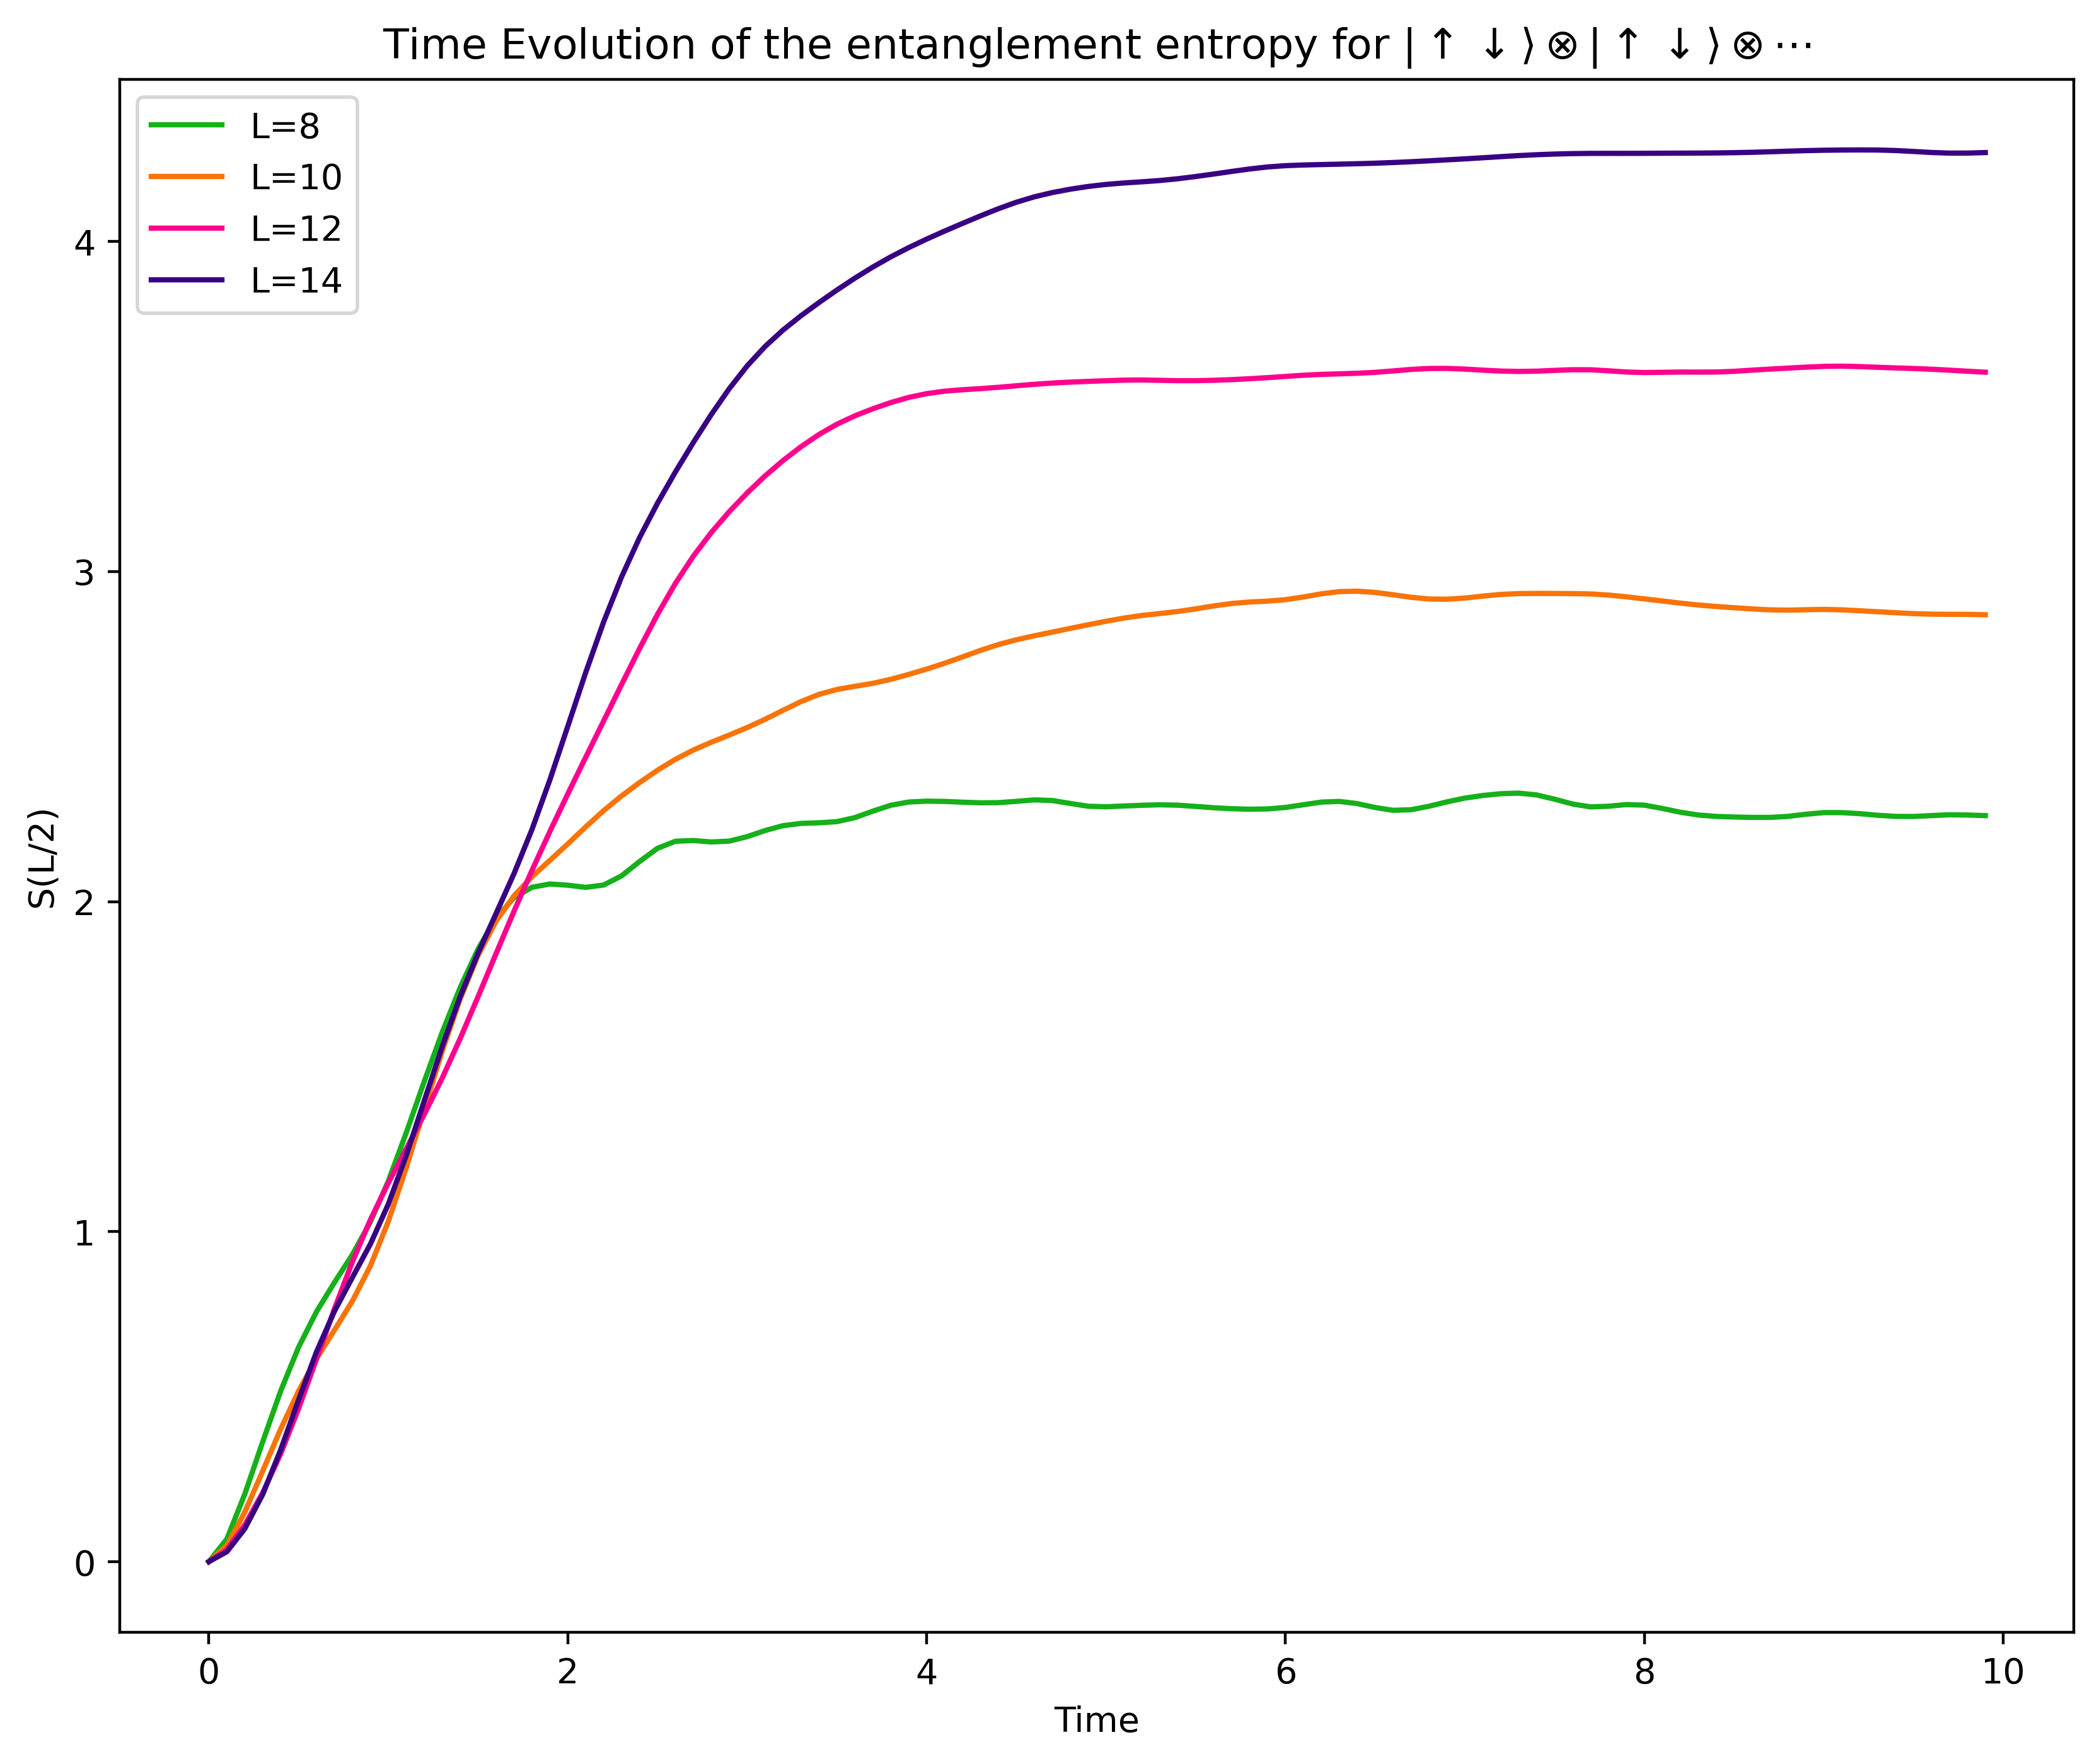

In [56]:
dt = .1
T = np.arange(0, 10, dt)

plt.figure(figsize=(10, 8))


for i in range(1, len(Ls)):
    
    L = Ls[i]
    eigs, vecs = eigss[i], vecss[i]
    psi = random_product_state(L)
    coeffs = vecs.conj().T @ psi
        
    Yarray = []
    for t in tqdm(T, desc=f'Processing L={L}'):
        Yarray.append(entanglement_entropy(L, L//2, coeffs, eigs, vecs, t))
        
    xkcd_colors=['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink', 'xkcd:indigo']

    plt.plot(T, Yarray, label=f'L={L}', color=xkcd_colors[i])
    



plt.xlabel('Time')
plt.ylabel(r'S(L/2)')
plt.title(r'Time Evolution of the entanglement entropy for $|\uparrow\downarrow\rangle\otimes|\uparrow\downarrow\rangle\otimes \cdots$')
plt.legend()
plt.savefig(os.path.join(directory, 'entropy_alternate.png'), dpi=400)
plt.show()
